# 5.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, f
from sklearn.linear_model import LinearRegression


In [2]:
# True population distribution (e.g., normal distribution)
true_distribution = np.random.normal(loc=0, scale=1, size=1000000)


In [3]:
# Function to calculate sample quantile
def calculate_sample_quantile(data, alpha):
    return np.percentile(data, 100 * alpha)

# Function to calculate jackknife standard error estimate for the sample quantile
def jackknife_standard_error(data, alpha):
    n = len(data)
    quantile_estimates = []

    for i in range(n):
        # Leave out the i-th observation
        sample_without_i = np.delete(data, i)
        
        # Calculate sample quantile for the subsample
        quantile_estimate_i = calculate_sample_quantile(sample_without_i, alpha)
        
        # Collect quantile estimates
        quantile_estimates.append(quantile_estimate_i)
    
    # Jackknife estimate of the variance
    var_jackknife = np.sum((quantile_estimates - np.mean(quantile_estimates))**2) * (n - 1) / n
    
    # Jackknife estimate of the standard error
    se_jackknife = np.sqrt(var_jackknife)

    return se_jackknife

# Function to calculate the true quantile, the sample quantile, its SE, and the SE provided by the Jackknife
def provide_statistics(distribution, α, n):
    
    sample_data = np.random.choice(distribution, size=n, replace=True)
    
    true_quantile = np.percentile(distribution, 100 * α)
    sample_quantile = np.percentile(sample_data, 100 * α)
    
    # Calculate standard error for the alpha-sample quantile
    s = np.std(sample_data, ddof=1)  # sample standard deviation
    z_alpha = norm.ppf(α)
    pdf_z_alpha = norm.pdf(z_alpha)
    se_quantile = s / np.sqrt(n * pdf_z_alpha)
    
    se_jackknife = jackknife_standard_error(sample_data, α)
    
    return true_quantile, sample_quantile, se_quantile, se_jackknife


In [23]:
np.random.seed(42)

iterations = 100

df = pd.DataFrame(columns=['Sample size', 'α', 'True quantile', 'Sample quantile', "Sample quantile's SE", 'Jackknife SE', "Jacknife SE / Sample quantile's SE"])
# Running the algorithm for a different α and sample sizes, and saving the results in a dataframe
for α in [0.25, 0.5, 0.75]:
    for n in [100, 1000, 5000]:
        l_sample_quantile, l_se_quantile, l_se_jackknife = [], [], []
        for _ in range(iterations):
            true_quantile, sample_quantile, se_quantile, se_jackknife = provide_statistics(true_distribution, α, n)
            l_sample_quantile.append(sample_quantile)
            l_se_quantile.append(se_quantile)
            l_se_jackknife.append(se_jackknife)
        sample_quantile = sum(l_sample_quantile) / iterations
        se_quantile = sum(l_se_quantile) / iterations
        se_jackknife = sum(l_se_jackknife) / iterations
        new_row = {'Sample size': n,
                   'α': α,
                   'True quantile': true_quantile,
                   'Sample quantile': sample_quantile,
                   "Sample quantile's SE": se_quantile,
                   'Jackknife SE': se_jackknife,
                   "Jacknife SE / Sample quantile's SE": se_jackknife/se_quantile}
        df = df.append(new_row, ignore_index=True)
        

In [24]:
# The results:
df


,Sample size,α,True quantile,Sample quantile,Sample quantile's SE,Jackknife SE,Jacknife SE / Sample quantile's SE
0,100.0,0.25,-0.673139,-0.681778,0.176464,0.146492,0.830151
1,1000.0,0.25,-0.673139,-0.671590,0.055978,0.040112,0.716561
2,5000.0,0.25,-0.673139,-0.673952,0.025030,0.018387,0.734631
3,100.0,0.50,0.000857,0.001564,0.157460,0.137934,0.875996
4,1000.0,0.50,0.000857,-0.002190,0.049981,0.040808,0.816467
5,5000.0,0.50,0.000857,-0.001077,0.022353,0.017212,0.769987
6,100.0,0.75,0.674142,0.639772,0.175492,0.125007,0.712324
7,1000.0,0.75,0.674142,0.673839,0.056028,0.044377,0.792055
8,5000.0,0.75,0.674142,0.674549,0.025135,0.017746,0.706055


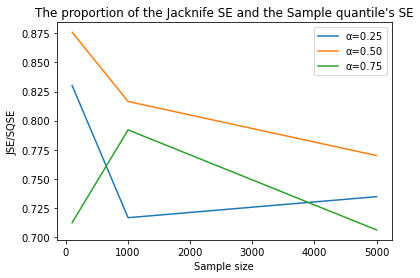

In [26]:
plt.plot(df.loc[:2, 'Sample size'], df.loc[:2, "Jacknife SE / Sample quantile's SE"], label='α=0.25')
plt.plot(df.loc[:2, 'Sample size'], df.loc[3:5, "Jacknife SE / Sample quantile's SE"], label='α=0.50')
plt.plot(df.loc[:2, 'Sample size'], df.loc[6:, "Jacknife SE / Sample quantile's SE"], label='α=0.75')
plt.xlabel('Sample size')
plt.ylabel('JSE/SQSE')
plt.title("The proportion of the Jacknife SE and the Sample quantile's SE")
plt.legend()

# Show the plot
plt.show()

# 5.2

In [1]:
# Create a function that provides plots w.r.t n and p
def generate_plots(n: int = 100, p: int = 10, t: int = 200) -> None:
    list_Y_0 = []
    list_ordinary_res = []
    list_loo_res = []
    for _ in range(t):
        # Generate X
        mean = np.zeros(p)
        covariance_matrix = np.eye(p)
        X = np.random.multivariate_normal(mean, covariance_matrix, n+1)
        # Generate u
        σ = 1
        u = np.random.normal(0, σ**2, n+1)
        # Create the true β and Y
        β = np.random.randn(p)
        Y = X @ β + u
        
        X_pred = X[1:]
        Y_pred = Y[1:]
        # Creating β_hat with ordinary OLS
        β_hat1 = np.linalg.inv(X_pred.T @ X_pred) @ X_pred.T @ Y_pred
        # Predicting Y_0 with OLS
        Y_0_hat = X[0] @ β_hat1
        res_Y_0 = Y[0] - Y_0_hat
        list_Y_0.append(res_Y_0)
        # Predicting other Y_i with OLS
        for i in range(n):
            Y_hat = X[i+1] @ β_hat1
            res_Y = Y[i+1] - Y_hat
            list_ordinary_res.append(res_Y)
        
        # Creating β_hat with loo OLS
        β_hat2 = np.zeros(p)
        for i in range(n):
            X_loo = np.delete(X_pred, i, axis=0)
            Y_loo = np.delete(Y_pred, i, axis=0)
            β_hat2 += np.linalg.inv(X_loo.T @ X_loo) @ X_loo.T @ Y_loo
        β_hat2 /= n + 1
        # Predicting other Y_i with loo OLS
        for i in range(n):
            Y_hat = X[i+1] @ β_hat2
            res_Y = Y[i+1] - Y_hat
            list_loo_res.append(res_Y)
            
    # Plot the distributions
    bins1 = np.linspace(-5, 5, int(np.sqrt(t)))
    bins2 = np.linspace(-5, 5, int(np.sqrt(t*n)))
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    
    axs[0].hist(list_Y_0, bins=bins1)
    axs[0].set_title(f'Distribution of the true unknown prediction error (n={n}, p={p})')
    
    axs[1].hist(list_ordinary_res, bins=bins2)
    axs[1].set_title(f'Empirical distribution of the ordinary residuals (n={n}, p={p})')
    
    axs[2].hist(list_loo_res, bins=bins2)
    axs[2].set_title(f'Empirical distribution of the leave-one-out residuals (n={n}, p={p})')
    
    plt.tight_layout()
    plt.show()



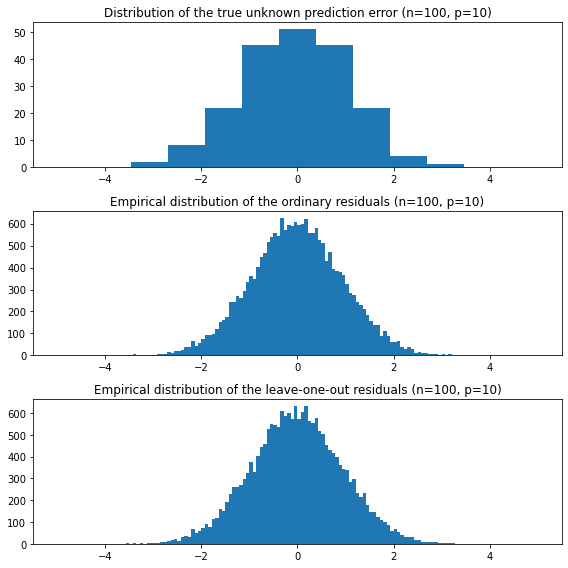

In [4]:
generate_plots(n=100, p=10)

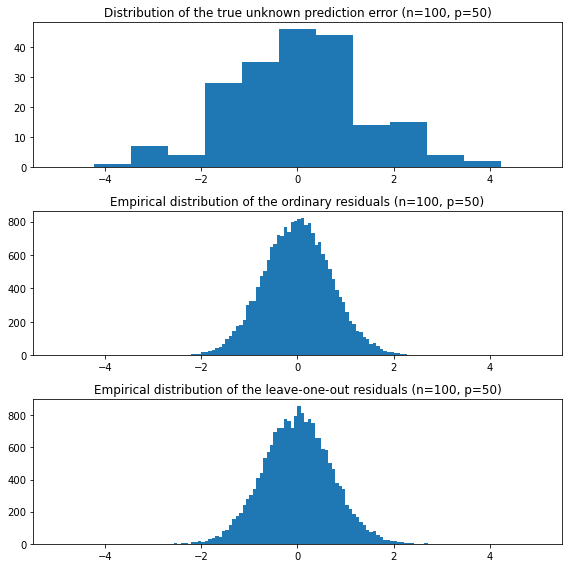

In [5]:
generate_plots(n=100, p=50)

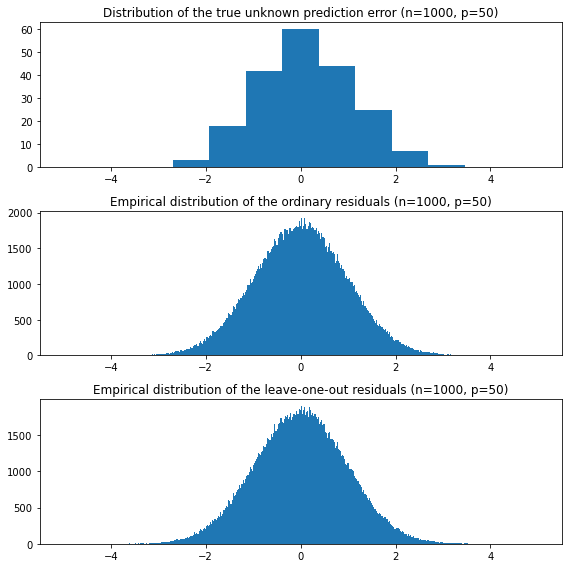

In [6]:
generate_plots(n=1000, p=50)

Both distributions look the same in the different cases, so they are equally suited to approximate the true unknown distribution error.
# 5.3
## a)

In [27]:
# Read the CSV file into a Pandas DataFrame
df_simpson = pd.read_csv('simpson.csv', delimiter=';')


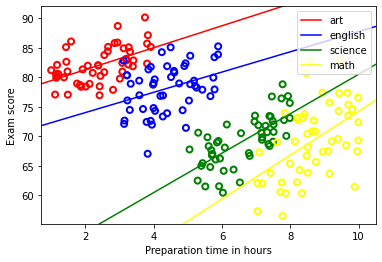

In [28]:
subjects = ['art', 'english', 'science', 'math']
colors = ['red', 'blue', 'green', 'yellow']

for subject, color in zip(subjects, colors):
    df = df_simpson.loc[df_simpson['subject'] == subject, ['score', 'time']]
    # Scatter plot
    plt.scatter(df['time'], df['score'], facecolors='none', edgecolors=color, linewidth=2)

    # Fit a linear regression line
    fit = np.polyfit(df['time'], df['score'], 1)
    x_values = np.linspace(df_simpson['time'].min() - 1, df_simpson['time'].max() + 1, 100)
    line = np.polyval(fit, x_values)

    # Plot the regression line
    plt.plot(x_values, line, color=color, label=subject)

plt.xlim(0.7, 10.5)
plt.ylim(55.2, 92)
plt.xlabel('Preparation time in hours')
plt.ylabel('Exam score')
plt.legend(loc='upper right')

# Display the plot
plt.show()


## b)

In [125]:
def f_test(β, R, r, X, Y):
    # initialize the constant variables
    q, p = R.shape
    n = len(X)
    
    # calculate σ
    σ = np.sqrt(np.sum((np.array(Y) - np.array(X) @ β)**2) / (n - p))
    
    # assistance calculations
    M = np.linalg.inv(R @ np.linalg.inv(X.T @ X) @ R.T)
    S = R @ β - r
    
    # calculating the measures
    f_value = float((S.T @ M @ S) / (q * σ**2))
    df1 = q
    df2 = n - p  
    p_value = 1 - f.cdf(f_value, df1, df2)
    
    return f_value, df1, df2, p_value


In [42]:
target_variable = df_simpson[['score']]


### i) First design matrix with R1

In [29]:
df_design_matrix_1 = df_simpson[['time', 'subject']].copy()
df_design_matrix_1['intercept'] = 1
df_design_matrix_1['intercept_english'] = (df_design_matrix_1['subject'] == 'english').astype(int)
df_design_matrix_1['intercept_science'] = (df_design_matrix_1['subject'] == 'science').astype(int)
df_design_matrix_1['intercept_math'] = (df_design_matrix_1['subject'] == 'math').astype(int)
df_design_matrix_1['english_time'] = df_design_matrix_1['intercept_english'] * df_design_matrix_1['time']
df_design_matrix_1['science_time'] = df_design_matrix_1['intercept_science'] * df_design_matrix_1['time']
df_design_matrix_1['math_time'] = df_design_matrix_1['intercept_math'] * df_design_matrix_1['time']
df_design_matrix_1.drop(columns='subject', inplace=True)


In [126]:
model1 = LinearRegression(fit_intercept=False)
model1.fit(df_design_matrix_1, target_variable)

LinearRegression(fit_intercept=False)

In [145]:
β1 = model1.coef_.T
R1 = np.zeros((3, 8))
R1[0, 5] = 1
R1[1, 6] = 1
R1[2, 7] = 1
r = np.array([[0], [0], [0]])


In [137]:
f_test(β1, R1, r1, df_design_matrix_1, target_variable)

(2.38767437511005, 3, 192, 0.07029430692767202)

### ii) First design matrix with R2

In [131]:
R2 = np.zeros((3, 8))
R2[0, 5] = 1
R2[1, 5] = 1
R2[1, 6] = -1
R2[2, 6] = 1
R2[2, 7] = -1


In [138]:
f_test(β1, R2, r1, df_design_matrix_1, target_variable)

(2.38767437511005, 3, 192, 0.07029430692767202)

### iii) Second design matrix with R3

In [30]:
df_design_matrix_2 = df_simpson[['time', 'subject']].copy()
df_design_matrix_2['intercept_art'] = (df_design_matrix_2['subject'] == 'art').astype(int)
df_design_matrix_2['intercept_english'] = (df_design_matrix_2['subject'] == 'english').astype(int)
df_design_matrix_2['intercept_science'] = (df_design_matrix_2['subject'] == 'science').astype(int)
df_design_matrix_2['intercept_math'] = (df_design_matrix_2['subject'] == 'math').astype(int)
df_design_matrix_2['art_time'] = df_design_matrix_2['intercept_art'] * df_design_matrix_2['time']
df_design_matrix_2['english_time'] = df_design_matrix_2['intercept_english'] * df_design_matrix_2['time']
df_design_matrix_2['science_time'] = df_design_matrix_2['intercept_science'] * df_design_matrix_2['time']
df_design_matrix_2['math_time'] = df_design_matrix_2['intercept_math'] * df_design_matrix_2['time']
df_design_matrix_2.drop(columns=['time', 'subject'], inplace=True)


In [139]:
model2 = LinearRegression(fit_intercept=False)
model2.fit(df_design_matrix_2, target_variable)

LinearRegression(fit_intercept=False)

In [146]:
β2 = model2.coef_.T
R3 = np.zeros((3, 8))
R3[0, 4] = 1
R3[0, 5] = -1
R3[1, 5] = 1
R3[1, 6] = -1
R3[2, 6] = 1
R3[2, 7] = -1


In [148]:
f_test(β2, R3, r, df_design_matrix_2, target_variable)

(2.3876743751100866, 3, 192, 0.07029430692766825)

### iv) Second design matrix with R4

In [147]:
R4 = np.zeros((3, 8))
R4[0, 4] = 1
R4[0, 5] = 1
R4[0, 6] = -1
R4[0, 7] = -1
R4[1, 4] = 1
R4[1, 5] = -1
R4[2, 6] = 1
R4[2, 7] = -1

In [149]:
f_test(β2, R4, r, df_design_matrix_2, target_variable)

(2.387674375110087, 3, 192, 0.07029430692766825)

### v) Conclusion
The different procedures are not in contradiction with each other, we should reject the null hypotheses in all cases.